# Finding the Protein in Multiple Databases

In [3]:
# Import necessary libraries
from collections import defaultdict
import requests
from Bio import ExPASy, SwissProt
import pandas as pd
import io

# Define the UniProt server URL
server = 'http://www.uniprot.org/uniprot'

# Function to send a request to the UniProt server
def do_request(server, ID='', **kwargs):
    params = ''
    req = requests.get('%s/%s%s' % (server, ID, params), params=kwargs)
    if not req.ok:
        req.raise_for_status()
    return req

# Send a request to the UniProt server to fetch information about the human gene 'p53'
# We are retrieving limited columns for 50 entries related to the gene 'p53' that have been reviewed
# Note: We might revisit this for KEGG data in the future
req = do_request(server, query='gene:p53 AND reviewed:yes', format='tab',
                 columns='id,entry name,length,organism,organism-id,database(PDB),database(HGNC)',
                 limit='50')

# Convert the response to a DataFrame using pandas
uniprot_list = pd.read_table(io.StringIO(req.text))
uniprot_list.rename(columns={'Organism ID': 'ID'}, inplace=True)

# Get the UniProt entry for the human gene 'p53'
p53_human = uniprot_list[
    (uniprot_list.ID == 9606) &
    (uniprot_list['Entry name'].str.contains('P53'))]['Entry'].iloc[0]

# Get the UniProt record for the specified entry (p53_human) using ExPASy
handle = ExPASy.get_sprot_raw(p53_human)
sp_rec = SwissProt.read(handle)

# Print some information about the UniProt record
print(sp_rec.entry_name, sp_rec.sequence_length, sp_rec.gene_name)
print(sp_rec.description)
print(sp_rec.organism, sp_rec.seqinfo)
print(sp_rec.sequence)

# Print comments and keywords associated with the UniProt record
print(sp_rec.comments)
print(sp_rec.keywords)

# Get a list of unique features in the UniProt record and print them
done_features = set()
print('Total features:', len(sp_rec.features))
for feature in sp_rec.features:
    if feature in done_features:
        continue
    else:
        done_features.add(feature)
        print(feature)

# Get a list of cross-references in the UniProt record, grouped by source, and print them
per_source = defaultdict(list)
for xref in sp_rec.cross_references:
    source = xref[0]
    per_source[source].append(xref[1:])
print(per_source.keys())

# Get a list of unique Gene Ontology (GO) annotations in the UniProt record and print them
done_GOs = set()
print('Annotation SOURCES:', len(per_source['GO']))
for annot in per_source['GO']:
    if annot[1][0] in done_GOs:
        continue
    else:
        done_GOs.add(annot[1][0])
        print(annot)


HTTPError: 400 Client Error: Bad Request for url: https://rest.uniprot.org/uniprotkb/query=gene:p53%20AND%20reviewed:yes&format=tab&columns=id,entry%20name,length,organism,organism-id,database(PDB),database(HGNC)&limit=50

# PDB Strcture Retrivial 

In [6]:
# Import the necessary modules from Biopython
from Bio import PDB
from Bio.SeqIO import PdbIO, FastaIO

# Create a PDBList object to retrieve PDB files from the PDB database
repository = PDB.PDBList()

# Retrieve PDB files for three different structures (1TUP, 1OLG, 1YCQ) and save them locally
repository.retrieve_pdb_file('1TUP', pdir='.', file_format='pdb')
repository.retrieve_pdb_file('1OLG', pdir='.', file_format='pdb')
repository.retrieve_pdb_file('1YCQ', pdir='.', file_format='pdb')

# Create a PDBParser object to parse the PDB files
parser = PDB.PDBParser()

# Parse the PDB files and create PDB structure objects for each structure
p53_1tup = parser.get_structure('P 53 - DNA Binding', 'pdb1tup.ent')
p53_1olg = parser.get_structure('P 53 - Tetramerization', 'pdb1olg.ent')
p53_1ycq = parser.get_structure('P 53 - Transactivation', 'pdb1ycq.ent')

# Function to print the header information of a PDB structure
def print_pdb_headers(headers, indent=0):
    ind_text = ' ' * indent
    for header, content in headers.items():
        if type(content) == dict:
            print('\n%s%20s:' % (ind_text, header))
            print_pdb_headers(content, indent + 4)
            print()
        elif type(content) == list:
            print('%s%20s:' % (ind_text, header))
            for elem in content:
                print('%s%21s %s' % (ind_text, '->', elem))
        else:
            print('%s%20s: %s' % (ind_text, header, content))

# Print the header information for the PDB structure p53_1tup
print_pdb_headers(p53_1tup.header)

# Function to describe the models in a PDB structure
def describe_model(name, pdb):
    print()
    for model in pdb:
        for chain in model:
            print('%s - Chain: %s. Number of residues: %d. Number of atoms: %d.' %
                  (name, chain.id, len(chain), len(list(chain.get_atoms()))))

# Describe the models in each of the three PDB structures
describe_model('1TUP', p53_1tup)
describe_model('1OLG', p53_1olg)
describe_model('1YCQ', p53_1ycq)

# Function to extract FASTA sequences from PDB files
def get_fasta(pdb_file, fasta_file, transfer_ids=None):
    fasta_writer = FastaIO.FastaWriter(fasta_file)
    fasta_writer.write_header()
    for rec in PdbIO.PdbSeqresIterator(pdb_file):
        if len(rec.seq) == 0:
            continue
        if transfer_ids is not None and rec.id not in transfer_ids:
            continue
        print(rec.id, rec.seq, len(rec.seq))
        fasta_writer.write_record(rec)

# Extract FASTA sequences for selected chains from each PDB structure
get_fasta(open('pdb1tup.ent'), open('1tup.fasta', 'w'), transfer_ids=['1TUP:B'])
get_fasta(open('pdb1olg.ent'), open('1olg.fasta', 'w'), transfer_ids=['1OLG:B'])
get_fasta(open('pdb1ycq.ent'), open('1ycq.fasta', 'w'), transfer_ids=['1YCQ:B'])


c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6146.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6147.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6148.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6149.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6171.
  warnings.warn(
c:\Users\92318\AppData\Local\P

                name: tumor suppressor p53 complexed with dna
                head: antitumor protein/dna
              idcode: 1TUP
     deposition_date: 1995-07-11
        release_date: 1995-07-11
    structure_method: x-ray diffraction
          resolution: 2.2
 structure_reference:
                   -> n.p.pavletich,k.a.chambers,c.o.pabo the dna-binding domain of p53 contains the four conserved regions and the major mutation hot spots genes dev. v. 7 2556 1993 issn 0890-9369 
                   -> b.vogelstein,k.w.kinzler p53 function and dysfunction cell(cambridge,mass.) v. 70 523 1992 issn 0092-8674 
   journal_reference: y.cho,s.gorina,p.d.jeffrey,n.p.pavletich crystal structure of a p53 tumor suppressor-dna complex: understanding tumorigenic mutations. science v. 265 346 1994 issn 0036-8075 8023157 
              author: Y.Cho,S.Gorina,P.D.Jeffrey,N.P.Pavletich

            compound:

                       1:
                        misc: 
                    molecule: dna (5

# Distance

In [7]:
import math
import timeit

from Bio import PDB

# Initialize the PDBList and PDBParser objects from Biopython.
repository = PDB.PDBList()
parser = PDB.PDBParser()

# Download the PDB file for structure 1TUP and parse it to create a PDB structure object.
repository.retrieve_pdb_file('1TUP', file_format='pdb', pdir='.')
p53_1tup = parser.get_structure('P 53', 'pdb1tup.ent')

# Find all zinc atoms ('ZN') in the PDB structure 1TUP and store them in the 'zns' list.
zns = []
for atom in p53_1tup.get_atoms():
    if atom.element == 'ZN':
        zns.append(atom)

# Print the coordinates of all zinc atoms in the structure.
for zn in zns:
    print(zn, zn.coord)

# Define a function 'get_closest_atoms' to get atoms within a certain distance of a reference atom.
def get_closest_atoms(pdb_struct, ref_atom, distance):
    atoms = {}
    rx, ry, rz = ref_atom.coord
    for atom in pdb_struct.get_atoms():
        if atom == ref_atom:
            continue
        x, y, z = atom.coord
        my_dist = math.sqrt((x - rx)**2 + (y - ry)**2 + (z - rz)**2)
        if my_dist < distance:
            atoms[atom] = my_dist
    return atoms

# Calculate the number of atoms within 4 Angstroms of each zinc atom and print the result.
for zn in zns:
    print()
    print(zn.coord)
    atoms = get_closest_atoms(p53_1tup, zn, 4)
    for atom, distance in atoms.items():
        print(atom.element, distance, atom.coord)

# Calculate the number of atoms within different distances (1, 2, 4, 8, 16, 32, 64, 128 Angstroms) of the zinc atoms.
for distance in [1, 2, 4, 8, 16, 32, 64, 128]:
    my_atoms = []
    for zn in zns:
        atoms = get_closest_atoms(p53_1tup, zn, distance)
        my_atoms.append(len(atoms))
    print(distance, my_atoms)

# Measure the average time taken to execute the 'get_closest_atoms' function for one execution.
nexecs = 10
print(timeit.timeit('get_closest_atoms(p53_1tup, zns[0], 4.0)',
                    'from __main__ import get_closest_atoms, p53_1tup, zns',
                    number=nexecs) / nexecs * 1000)

# Define an optimized version of the 'get_closest_atoms' function using alternative coordinate comparisons.
def get_closest_alternative(pdb_struct, ref_atom, distance):
    atoms = {}
    rx, ry, rz = ref_atom.coord
    for atom in pdb_struct.get_atoms():
        if atom == ref_atom:
            continue
        x, y, z = atom.coord
        if abs(x - rx) > distance or abs(y - ry) > distance or abs(z - rz) > distance:
            continue
        my_dist = math.sqrt((x - rx)**2 + (y - ry)**2 + (z - rz)**2)
        if my_dist < distance:
            atoms[atom] = my_dist
    return atoms

# Measure the average time taken to execute the 'get_closest_alternative' function for one execution.
print(timeit.timeit('get_closest_alternative(p53_1tup, zns[0], 4.0)',
                    'from __main__ import get_closest_alternative, p53_1tup, zns',
                    number=nexecs) / nexecs * 1000)

# Compare the execution times of the standard and optimized versions of the function for different distances.
print('Standard')
for distance in [1, 4, 16, 64, 128]:
    print(timeit.timeit('get_closest_atoms(p53_1tup, zns[0], distance)',
                        'from __main__ import get_closest_atoms, p53_1tup, zns, distance',
                        number=nexecs) / nexecs * 1000)

print('Optimized')
for distance in [1, 4, 16, 64, 128]:
    print(timeit.timeit('get_closest_alternative(p53_1tup, zns[0], distance)',
                        'from __main__ import get_closest_alternative, p53_1tup, zns, distance',
                        number=nexecs) / nexecs * 1000)

# Note: The comment "#for interesting distances" suggests further exploration with specific distances.


Structure exists: '.\pdb1tup.ent' 
<Atom ZN> [58.108 23.242 57.424]
<Atom ZN> [60.108 17.981 75.931]
<Atom ZN> [33.653  0.403 74.115]

[58.108 23.242 57.424]
C 3.4080117696286854 [57.77  21.214 60.142]
S 2.3262243799594877 [57.065 21.452 58.482]
C 3.4566537492335123 [58.886 20.867 55.036]
C 3.064120559761192 [58.047 22.038 54.607]
N 1.9918273537290707 [57.755 23.073 55.471]
C 2.9243719601324525 [56.993 23.943 54.813]
C 3.857729198122736 [61.148 25.061 55.897]
C 3.62725094648044 [61.61  24.087 57.001]
S 2.2789209624943494 [60.317 23.318 57.979]
C 3.087214470667822 [57.205 25.099 59.719]
S 2.2253158446520818 [56.914 25.054 57.917]

[60.108 17.981 75.931]


c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6146.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6147.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6148.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6149.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6171.
  warnings.warn(
c:\Users\92318\AppData\Local\P

C 3.41769274437124 [57.593 15.783 75.207]
S 2.3254721582053093 [58.586 17.082 74.42 ]
C 3.4672070967122894 [62.272 17.174 73.345]
C 3.1139134725185587 [62.061 18.615 73.59 ]
N 2.0564599972249455 [61.366 19.056 74.71 ]
C 2.985233217423681 [61.332 20.382 74.647]
C 3.805126390272999 [62.573 18.263 78.816]
C 3.1803200512467478 [61.521 17.136 78.652]
S 2.2070404885225816 [61.287 16.447 76.993]
C 3.2038921042012745 [57.624 18.417 77.907]
S 2.242320906916762 [58.978 19.402 77.247]

[33.653  0.403 74.115]
N 3.8418381161044053 [32.62  -3.267 73.642]
C 3.4269003358801373 [31.435 -1.557 72.388]
S 2.3788014279880345 [32.942 -0.607 72.082]
C 3.1575681467123577 [36.183 -0.469 72.439]
C 2.985114661190097 [36.225  0.98  72.714]
N 2.0959130049879975 [35.24   1.603 73.456]
C 3.2037898879982705 [35.569  2.894 73.492]
C 3.940504780036419 [35.474  0.462 77.609]
C 3.4076262123188337 [34.442 -0.639 77.262]
S 2.3204200227887206 [34.453 -1.233 75.553]
C 3.076855853166918 [30.82   1.082 75.105]
S 2.131504416094

# Mass 

In [8]:
import numpy as np
import pandas as pd

from Bio import PDB

# Download the PDB file for structure 1TUP and parse it to create a PDB structure object.
repository = PDB.PDBList()
parser = PDB.PDBParser()
repository.retrieve_pdb_file('1TUP', pdir='.', file_format='pdb')
p53_1tup = parser.get_structure('P 53', 'pdb1tup.ent')

# Extract unique residue IDs from the PDB structure and print them.
my_residues = set()
for residue in p53_1tup.get_residues():
    my_residues.add(residue.id[0])
print(my_residues)

# Define a function 'get_mass' to calculate the mass of a group of atoms, with an optional filtering function.
def get_mass(atoms, accept_fun=lambda atom: atom.parent.id[0] != 'W'):
    return sum([atom.mass for atom in atoms if accept_fun(atom)])

# Calculate the mass of atoms in each chain of the PDB structure and store the results in a DataFrame.
chain_names = [chain.id for chain in p53_1tup.get_chains()]
my_mass = np.ndarray((len(chain_names), 3))
for i, chain in enumerate(p53_1tup.get_chains()):
    my_mass[i, 0] = get_mass(chain.get_atoms())
    my_mass[i, 1] = get_mass(chain.get_atoms(), accept_fun=lambda atom: atom.parent.id[0] not in [' ', 'W'])
    my_mass[i, 2] = get_mass(chain.get_atoms(), accept_fun=lambda atom: atom.parent.id[0] == 'W')
masses = pd.DataFrame(my_mass, index=chain_names, columns=['No Water', 'Zincs', 'Water'])
masses

# Define a function 'get_center' to calculate the center of a group of atoms, with an optional weighting function.
def get_center(atoms, weight_fun=lambda atom: 1 if atom.parent.id[0] != 'W' else 0):
    xsum = ysum = zsum = 0.0
    acum = 0.0
    for atom in atoms:
        x, y, z = atom.coord
        weight = weight_fun(atom)
        acum += weight
        xsum += weight * x
        ysum += weight * y
        zsum += weight * z
    return xsum / acum, ysum / acum, zsum / acum

# Calculate the center of all atoms and atoms weighted by mass for each chain in the PDB structure.
print(get_center(p53_1tup.get_atoms()))
print(get_center(p53_1tup.get_atoms(), weight_fun=lambda atom: atom.mass if atom.parent.id[0] != 'W' else 0))

my_center = np.ndarray((len(chain_names), 6))
for i, chain in enumerate(p53_1tup.get_chains()):
    x, y, z = get_center(chain.get_atoms())
    my_center[i, 0] = x
    my_center[i, 1] = y
    my_center[i, 2] = z
    x, y, z = get_center(chain.get_atoms(), weight_fun=lambda atom: atom.mass if atom.parent.id[0] != 'W' else 0)
    my_center[i, 3] = x
    my_center[i, 4] = y
    my_center[i, 5] = z
weights = pd.DataFrame(my_center, index=chain_names, columns=['X', 'Y', 'Z', 'X (Mass)', 'Y (Mass)', 'Z (Mass)'])
weights

# Note: The comment "#Pymol viz" suggests visualizing the results using PyMOL.


Structure exists: '.\pdb1tup.ent' 
{'W', 'H_ZN', ' '}


c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6146.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6147.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6148.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6149.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6171.
  warnings.warn(
c:\Users\92318\AppData\Local\P

(58.296333984624454, 15.48705585839803, 78.40529502795778)
(58.12261138092647, 15.751286500376127, 78.37537036885965)


,X,Y,Z,X (Mass),Y (Mass),Z (Mass)
E,49.727231,32.744879,81.253417,49.708513,32.759725,81.207395
F,51.982368,33.843370,81.578795,52.002223,33.820064,81.624394
A,72.990763,28.825429,56.714012,72.822668,28.810327,56.716117
B,67.810026,12.624435,88.656590,67.729100,12.724130,88.545659
C,38.221565,-5.010494,88.293141,38.169364,-4.915395,88.166711


# Parser

In [9]:
from Bio import PDB

# Import the required libraries.

# Create a PDBList object to interact with the Protein Data Bank (PDB) repository.
# Download the PDB file for structure 1TUP and save it in the current directory.
repository = PDB.PDBList()
repository.retrieve_pdb_file('1TUP', pdir='.', file_format='pdb')

# Define a dictionary 'rec_types' that maps each PDB record type to its fields and their respective data types.
# Example: 'HEADER' record type has fields [(str, 11, 49), (str, 50, 58), (str, 62, 65)].
# 'HEADER' record type contains three fields with data types string, string, and string, respectively.
rec_types = {
    # Single line record type example
    'HEADER': [(str, 11, 49), (str, 50, 58), (str, 62, 65)],
    # Multi-line record type example
    'SOURCE': [(int, 7, 9), (str, 10, 78)],
    # Multi-record record type example
    'LINK' : [(str, 12, 15), ...],
    ...
}

# Define a function 'parse_pdb' to parse the PDB file and extract the records based on their defined fields.
# The function yields a tuple containing the record type and its corresponding fields data.
def parse_pdb(hdl):
    ...

# Open the PDB file and parse the records using 'parse_pdb' function.
# Print the parsed records.
hdl = open('pdb1tup.ent')
done_rec = set()
for rec in parse_pdb(hdl):
    ...

# Define a list 'multi_lines' to store record types with multi-line values.
multi_lines = ['SOURCE']

# Define a function 'process_multi_lines' to process multi-line record types.
# The function yields the multi-line record type and its corresponding multi-line values.
def process_multi_lines(hdl):
    ...

# Open the PDB file again and process the multi-line record types using 'process_multi_lines' function.
# Print the processed multi-line records.
hdl = open('pdb1tup.ent')
done_rec = set()
for rec in process_multi_lines(hdl):
    ...

# Define a function 'get_spec_list' to parse a string and extract specification list.
# The function returns a dictionary containing the specification list.
def get_spec_list(my_str):
    ...

# Define a dictionary 'struct_types' that maps each record type with structured information to their corresponding parsing functions.
# Example: 'SOURCE' record type is associated with 'get_spec_list' function.
struct_types = {
    'SOURCE': [get_spec_list] 
}

# Define a function 'process_struct_types' to process record types with structured information.
# The function yields the structured record type and its corresponding structured information.
def process_struct_types(hdl):
    ...

# Open the PDB file again and process the structured record types using 'process_struct_types' function.
# Print the processed structured records.
hdl = open('pdb1tup.ent')
for rec in process_struct_types(hdl):
    if rec[0] != 'SOURCE':
        continue
    print(rec)


Structure exists: '.\pdb1tup.ent' 
('HEADER', ['NTITUMOR PROTEIN/DNA                   ', '11-JUL-95', '1TUP'])
('SOURCE', [None, 'MOL_ID: 1;                                                           '])
('HELIX', [1, '  1', 'SER', 'A', 166, ' ', 'HIS', 'A', 168, ' ', 5, '                              ', 3])
('SHEET', [1, '  A', 4, 'ARG', 'A', 11, ' ', 'GLY', 'A', 112, ' ', 0, '    ', '   ', ' ', None, ' ', '    ', '   ', ' ', None, ' '])
('LINK', ['ZN  ', ' ', ' ZN', 'A', 951, ' ', ' SG ', ' ', 'CYS', 'A', 176, ' ', '  1555', '  1555', 2.33])
('HEADER', ['NTITUMOR PROTEIN/DNA                   ', '11-JUL-95', '1TUP'])
('SOURCE', ['MOL_ID: 1; SYNTHETIC: YES; MOL_ID: 2; SYNTHETIC: YES; MOL_ID: 3; ORGANISM_SCIENTIFIC: HOMO SAPIENS; ORGANISM_COMMON: HUMAN; ORGANISM_TAXID: 9606; CELL_LINE: A431; CELL: HUMAN VULVA CARCINOMA; EXPRESSION_SYSTEM: ESCHERICHIA COLI; EXPRESSION_SYSTEM_TAXID: 562; EXPRESSION_SYSTEM_PLASMID: PET3D '])
('HELIX', [1, '  1', 'SER', 'A', 166, ' ', 'HIS', 'A', 168, ' ',

# Molecular visualization  Multi-threading functionality

In [13]:
# Import threading module for multi-threading functionality
import threading

# Define a function to print information about currently running threads
def dump_thread():
    print
    for thr in threading.enumerate():
        print(thr)

# Call dump_thread to print thread information before PyMOL launch
dump_thread()

# Import PyMOL module
import pymol

# Set the number of PyMOL launches to 4 to enable multi-threading
pymol.pymol_launch=4

# Configure PyMOL to run in quiet mode (no GUI) with the specified arguments
pymol.pymol_argv = [ 'pymol', '-qc']

# Import the PyMOL command module
from pymol import cmd

# Finish launching PyMOL with the specified configurations
pymol.finish_launching()

# Call dump_thread to print thread information after PyMOL launch
dump_thread()

# Fetch the PDB file for structure 1TUP from the PDB database
cmd.fetch('1TUP')

# Disable all objects to clear the display
cmd.disable('all')

# Enable only the loaded 3D structure (1TUP)
cmd.enable('1TUP')

# Set the background color to white
cmd.bg_color('white')

# Hide all display representations
cmd.hide('all')

# Show the cartoon representation of the 3D structure
cmd.show('cartoon')

# Optionally, you can hide specific display representations (e.g., ribbon) or show additional representations

# Select zinc atoms from the structure and show them as spheres
cmd.select('zinc', 'name zn')
cmd.show('sphere', 'zinc')

# Set the ray tracing mode to 3 for improved image quality
cmd.set('ray_trace_mode', 3)

# Generate a high-resolution PNG image of the structure (1TUP.png) with specified width, height, and other settings
cmd.png('1TUP.png', width=1980, height=1080, quiet=0, ray=1, prior=False)

# Call dump_thread to print thread information after image generation
dump_thread()

# Reset the ray tracing mode to 1 for faster rendering in the subsequent command
cmd.set('ray_trace_mode', 1)

# Generate a second PNG image (TUP.png) with the updated settings
cmd.png('TUP.png', width=1980, height=1080, quiet=0, ray=1, prior=False)

# Quit PyMOL
cmd.quit()


<_MainThread(MainThread, started 4260)>
<Thread(Thread-6 (_thread_main), started daemon 19372)>
<Heartbeat(Thread-7, started daemon 16928)>
<ControlThread(Thread-5, started daemon 8488)>
<HistorySavingThread(IPythonHistorySavingThread, started 24732)>
<ParentPollerWindows(Thread-4, started daemon 13964)>


ModuleNotFoundError: No module named 'pymol'

# Extracting more information from a PDB file

Structure exists: '.\pdb1tup.ent' 
{'DT': 257, 'DC': 152, 'DA': 270, 'DG': 176, 'HOH': 384, 'SER': 323, 'VAL': 315, 'PRO': 294, 'GLN': 189, 'LYS': 135, 'THR': 294, 'TYR': 288, 'GLY': 156, 'PHE': 165, 'ARG': 561, 'LEU': 336, 'HIS': 210, 'ALA': 105, 'CYS': 180, 'ASN': 216, 'MET': 144, 'TRP': 42, 'ASP': 192, 'ILE': 144, 'GLU': 297, 'ZN': 3}
{'E': 442, 'F': 449, 'A': 1734, 'B': 1593, 'C': 1610}
{'O': 1114, 'C': 3238, 'N': 1001, 'P': 40, 'S': 48, 'ZN': 3}
{'DT': 13, 'DC': 8, 'DA': 13, 'DG': 8, 'HOH': 384, 'SER': 54, 'VAL': 45, 'PRO': 42, 'GLN': 21, 'LYS': 15, 'THR': 42, 'TYR': 24, 'GLY': 39, 'PHE': 15, 'ARG': 51, 'LEU': 42, 'HIS': 21, 'ALA': 21, 'CYS': 30, 'ASN': 27, 'MET': 18, 'TRP': 3, 'ASP': 24, 'ILE': 18, 'GLU': 33, 'ZN': 3}
{'E': 43, 'F': 35, 'A': 395, 'B': 265, 'C': 276}
E ([22.989, 6.224, 68.526], [83.134, 52.07, 93.047])
F ([18.075, 17.921, 67.133], [81.553, 51.854, 92.927])
A ([47.913, 3.146, 35.011], [101.837, 52.296, 81.497])
B ([46.526, -9.607, 61.584], [94.363, 37.123, 108.068]

c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6146.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6147.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6148.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6149.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6171.
  warnings.warn(
c:\Users\92318\AppData\Local\P

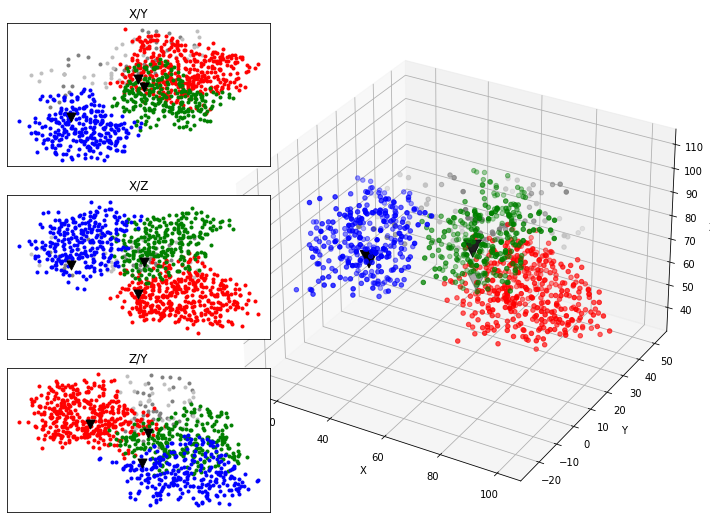

In [14]:
# Import required modules
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import the Bio.PDB module from Biopython
from Bio import PDB

# -

# Initialize the PDBList and PDBParser objects
repository = PDB.PDBList()
parser = PDB.PDBParser()

# Retrieve the PDB file '1TUP' and store it in the current directory (pdir='.') in PDB file format
repository.retrieve_pdb_file('1TUP', pdir='.', file_format='pdb') #XXX

# Parse the retrieved PDB file using the PDBParser and assign the structure to the variable 'p53_1tup'
p53_1tup = parser.get_structure('P 53', 'pdb1tup.ent')

# +
# Initialize defaultdicts to store various statistics
atom_cnt = defaultdict(int)
atom_chain = defaultdict(int)
atom_res_types = defaultdict(int)

# Loop through all atoms in the structure to calculate statistics
for atom in p53_1tup.get_atoms():
    my_residue = atom.parent
    my_chain = my_residue.parent
    atom_chain[my_chain.id] += 1
    if my_residue.resname != 'HOH':
        atom_cnt[atom.element] += 1
    atom_res_types[my_residue.resname] += 1

# Print statistics of atom count per residue type, chain, and atom element
print(dict(atom_res_types))
print(dict(atom_chain))
print(dict(atom_cnt))
# -

# Initialize defaultdicts to store statistics related to residue types and residues per chain
res_types = defaultdict(int)
res_per_chain = defaultdict(int)

# Loop through all residues in the structure to calculate statistics
for residue in p53_1tup.get_residues():
    res_types[residue.resname] += 1
    res_per_chain[residue.parent.id] += 1

# Print statistics of residue count per residue type and residue count per chain
print(dict(res_types))
print(dict(res_per_chain))


# Define a function to calculate the bounding box (minimum and maximum coordinates) of a list of atoms
def get_bounds(my_atoms):
    my_min = [sys.maxsize] * 3
    my_max = [-sys.maxsize] * 3
    for atom in my_atoms:
        for i, coord in enumerate(atom.coord):
            if coord < my_min[i]:
                my_min[i] = coord
            if coord > my_max[i]:
                my_max[i] = coord
    return my_min, my_max


# Initialize a dictionary to store bounding boxes for each chain
chain_bounds = {}

# Loop through all chains in the structure to calculate their bounding boxes
for chain in p53_1tup.get_chains():
    print(chain.id, get_bounds(chain.get_atoms()))
    chain_bounds[chain.id] = get_bounds(chain.get_atoms())

# Calculate and print the bounding box of the entire structure
print(get_bounds(p53_1tup.get_atoms()))

# Matplotlib 3D plot to visualize the 3D structure and its chains
fig = plt.figure(figsize=(16, 9))
ax3d = fig.add_subplot(111, projection='3d')
ax_xy = fig.add_subplot(331)
ax_xy.set_title('X/Y')
ax_xz = fig.add_subplot(334)
ax_xz.set_title('X/Z')
ax_zy = fig.add_subplot(337)
ax_zy.set_title('Z/Y')
color = {'A': 'r', 'B': 'g', 'C': 'b', 'E': '0.5', 'F': '0.75'}
zx, zy, zz = [], [], []

# Loop through all chains and residues to plot atoms and residues in the 3D space and on 2D planes
for chain in p53_1tup.get_chains():
    xs, ys, zs = [], [], []
    for residue in chain.get_residues():
        ref_atom = next(residue.get_iterator())
        x, y, z = ref_atom.coord
        if ref_atom.element == 'ZN':
            zx.append(x)
            zy.append(y)
            zz.append(z)
            continue
        xs.append(x)
        ys.append(y)
        zs.append(z)
    ax3d.scatter(xs, ys, zs, color=color[chain.id])
    ax_xy.scatter(xs, ys, marker='.', color=color[chain.id])
    ax_xz.scatter(xs, zs, marker='.', color=color[chain.id])
    ax_zy.scatter(zs, ys, marker='.', color=color[chain.id])

# Set axis labels and plot zinc atoms as special markers
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')
ax3d.scatter(zx, zy, zz, color='k', marker='v', s=300)
ax_xy.scatter(zx, zy, color='k', marker='v', s=80)
ax_xz.scatter(zx, zz, color='k', marker='v', s=80)
ax_zy.scatter(zz, zy, color='k', marker='v', s=80)

# Hide axis ticks and labels for 2D planes
for ax in [ax_xy, ax_xz, ax_zy]:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


# Animating Protein Structure

In [17]:
# Import pymol and the cmd module from pymol
import pymol
from pymol import cmd

# Finish launching PyMOL
pymol.finish_launching()

# Fetch the PDB file '1TUP' from the Protein Data Bank
cmd.fetch('1TUP')

# Disable all representations, enable representation for structure '1TUP', and show zinc atoms as spheres
cmd.disable('all')
cmd.enable('1TUP')
cmd.hide('all')
cmd.show('sphere', 'name zn')

# Show the surface representation for chains A, B, and C and the cartoon representation for chains E and F
cmd.show('surface', 'chain A+B+C')
cmd.show('cartoon', 'chain E+F')

# Create a new scene 'S0' and store the current view
cmd.scene('S0', action='store', view=0, frame=0, animate=-1)

# Show the cartoon representation and hide the surface representation
cmd.show('cartoon')
cmd.hide('surface')

# Create a new scene 'S1' and store the current view
cmd.scene('S1', action='store', view=0, frame=0, animate=-1)

# Hide the cartoon representation for chains A, B, and C, show the mesh representation for chain A,
# and show the sticks representation for chains A, B, and C
cmd.hide('cartoon', 'chain A+B+C')
cmd.show('mesh', 'chain A')
cmd.show('sticks', 'chain A+B+C')

# Create a new scene 'S2' and store the current view
cmd.scene('S2', action='store', view=0, frame=0, animate=-1)

# Set the ray trace mode to 0 (no ray tracing) and create a movie with 500 frames
cmd.set('ray_trace_mode', 0)
cmd.mset(1, 500)

# Set the view and create keyframes for specific frames
cmd.frame(0)
cmd.scene('S0')
cmd.mview()

cmd.frame(60)
cmd.set_view((-0.175534308,   -0.331560850,   -0.926960170,
             0.541812420,     0.753615797,   -0.372158051,
             0.821965039,    -0.567564785,    0.047358301,
             0.000000000,     0.000000000, -249.619018555,
             58.625568390,   15.602619171,   77.781631470,
             196.801528931, 302.436492920,  -20.000000000))

cmd.mview()

cmd.frame(90)
cmd.set_view((-0.175534308,   -0.331560850,   -0.926960170,
              0.541812420,    0.753615797,   -0.372158051,
              0.821965039,   -0.567564785,    0.047358301,
              -0.000067875,    0.000017881, -249.615447998,
              54.029174805,   26.956727982,   77.124832153,
             196.801528931,  302.436492920,  -20.000000000))

cmd.mview()

cmd.frame(150)
cmd.set_view((-0.175534308,   -0.331560850,   -0.926960170,
              0.541812420,    0.753615797,   -0.372158051,
              0.821965039,   -0.567564785,    0.047358301,
              -0.000067875,    0.000017881,  -55.406421661,
              54.029174805,   26.956727982,   77.124832153,
              2.592475891,  108.227416992,  -20.000000000))

cmd.mview()

cmd.frame(200)
cmd.scene('S1')
cmd.mview()

cmd.frame(350)
cmd.scene('S1')
cmd.set_view((0.395763457,   -0.173441306,    0.901825786,
              0.915456235,    0.152441502,   -0.372427106,
             -0.072881661,    0.972972929,    0.219108686,
              0.000070953,    0.000013039,  -37.689743042,
             57.748500824,   14.325904846,   77.241867065,
             -15.123448372,   90.511535645,  -20.000000000))

cmd.mview()

cmd.frame(351)
cmd.scene('S2')
cmd.mview()

cmd.frame(500)
cmd.scene('S2')
cmd.mview()

# Play the movie and save it as PNG images with the prefix 'p53_1tup'
cmd.mplay()
cmd.mpng('p53_1tup')

# Quit PyMOL
cmd.quit()


ModuleNotFoundError: No module named 'pymol'

# Parsing mmCIF files

In [16]:
# Import PDB module from Biopython
from Bio import PDB

# Download the PDB file '1TUP' in CIF format and parse it using the MMCIFParser
# Note: The wget command and file download are commented out to avoid unnecessary downloads in the notebook environment.
#      If you run the code in your local environment, you can uncomment these lines to download the file.
# !rm -f 1tup.cif 2>/dev/null
# !wget "http://www.rcsb.org/pdb/download/downloadFile.do?fileFormat=cif&compression=NO&structureId=1TUP" -O 1tup.cif
parser = PDB.MMCIFParser()
p53_1tup = parser.get_structure('P53_HUMAN', '1tup.cif')

# Function to describe the model (structure) details
def describe_model(name, pdb):
    print()
    for model in p53_1tup:
        for chain in model:
            print('%s - Chain: %s. Number of residues: %d. Number of atoms: %d.' %
                  (name, chain.id, len(chain), len(list(chain.get_atoms()))))

# Describe the details of the structure '1TUP'
describe_model('1TUP', p53_1tup)

# Initialize a set to keep track of the processed chains
done_chain = set()

# Loop through all the residues in the structure '1TUP' and print the chain IDs and residue IDs
for residue in p53_1tup.get_residues():
    chain = residue.parent
    if chain.id in done_chain:
        continue
    done_chain.add(chain.id)
    print(chain.id, residue.id)

# Parse the CIF file into a dictionary using MMCIF2Dict
mmcif_dict = PDB.MMCIF2Dict.MMCIF2Dict('1tup.cif')

# Print the content of the CIF file dictionary
for k, v in mmcif_dict.items():
    print(k, v)
    print()


c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5441.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5442.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5443.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 5444.
  warnings.warn(
c:\Users\92318\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 5466.
  warnings.warn(
c:\Users\92318\AppData\Local\P


1TUP - Chain: E. Number of residues: 43. Number of atoms: 442.
1TUP - Chain: F. Number of residues: 35. Number of atoms: 449.
1TUP - Chain: A. Number of residues: 395. Number of atoms: 1734.
1TUP - Chain: B. Number of residues: 265. Number of atoms: 1593.
1TUP - Chain: C. Number of residues: 276. Number of atoms: 1610.
E (' ', 1001, ' ')
F (' ', 1101, ' ')
A (' ', 94, ' ')
B (' ', 96, ' ')
C (' ', 95, ' ')
data_ 1TUP

_entry.id ['1TUP']

_audit_conform.dict_name ['mmcif_pdbx.dic']

_audit_conform.dict_version ['5.279']

_audit_conform.dict_location ['http://mmcif.pdb.org/dictionaries/ascii/mmcif_pdbx.dic']

_database_2.database_id ['PDB', 'RCSB', 'WWPDB']

_database_2.database_code ['1TUP', 'PDR027', 'D_1000176862']

_pdbx_database_status.status_code ['REL']

_pdbx_database_status.entry_id ['1TUP']

_pdbx_database_status.recvd_initial_deposition_date ['1995-07-11']

_pdbx_database_status.deposit_site ['?']

_pdbx_database_status.process_site ['NDB']

_pdbx_database_status.SG_entry ['.